# Bài tập Colab: Dự đoán điểm cuối kỳ của sinh viên thông qua việc nộp bài tập Wecode

Thành viên:
- Lê Trần Trọng Khiêm - 19521689
- Trần Tiến Hưng - 19521587
- Lê Đặng Đăng Huy - 19521612

Các mục dưới đây là copy lại từ bài colab vẽ scatter plot trước.

## Download và load dữ liệu bằng pandas

Import thư viện cần thiết

In [602]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Tải dữ liệu từ Google Drive

In [603]:
!gdown --id 1OP3vs6PYcC9Of0LTBakOmwLnXO4NEtF2

Downloading...
From: https://drive.google.com/uc?id=1OP3vs6PYcC9Of0LTBakOmwLnXO4NEtF2
To: /content/score_training.csv
100% 23.9k/23.9k [00:00<00:00, 42.4MB/s]


In [604]:
!gdown --id 1Zwvd4V1p63PTX3G1fwr0jyGkT8pXZHRO

Downloading...
From: https://drive.google.com/uc?id=1Zwvd4V1p63PTX3G1fwr0jyGkT8pXZHRO
To: /content/wecode.csv
30.8MB [00:00, 144MB/s]


Load dữ liệu với pandas

In [605]:
wecode = pd.read_csv('wecode.csv')
score = pd.read_csv('score_training.csv', na_values=['\xa0'])

In [606]:
wecode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coefficient    264606 non-null  object
 8   file_name      264606 non-null  object
 9   language_id    264606 non-null  int64 
 10  created_at     264606 non-null  object
 11  updated_at     264606 non-null  object
dtypes: int64(7), object(5)
memory usage: 24.2+ MB


In [607]:
score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      975 non-null    int64  
 1   QT      891 non-null    float64
 2   GK      836 non-null    float64
 3   TH      892 non-null    float64
 4   CK      920 non-null    float64
 5   TBM     786 non-null    float64
 6   TBTL    972 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 53.4 KB


## Tính toán các thông số có thể ảnh hưởng đến điểm cuối kỳ

Các thông tin trong file wecode nếu để nguyên như vậy sẽ không thể thấy được mối liên hệ giữa nó với điểm cuối kỳ. Mình sẽ cần tính các thông số sau:

- Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số problem có submit
- Tổng số problem đã sumbit / Tổng số submissions
- Số lần submit đúng (pre_score=10000) / tổng số submissions
- Tổng pre_score của các submssion có is_final = 1
- Trung bình của coefficient



Đầu tiên cần phải kiểm tra problem đã solved chưa và đếm số các assignment, problem, submission. Problem đã solved sẽ có final = 1 và prescore = 10000

In [608]:
def is_solved(x):
  if x['is_final'] == 1 and x['pre_score'] == 10000:
    return 1
  return 0

wecode['solved'] = wecode.apply(is_solved, axis=1)

no_assignment = wecode.assignment_id.nunique()
no_problem = wecode.problem_id.nunique()
no_submission = wecode.id.count()
no_problem_per_assignment = no_problem / no_assignment

Drop coefficient = error để chuyển thành kiểu số

In [609]:
# Số coefficient = error
wecode[wecode.coefficient == 'error'].id.count()

252

In [610]:
wecode = wecode[wecode.coefficient != 'error']
wecode['coefficient'] = wecode.coefficient.astype(int)

Tiếp theo mình cần group theo user_id để thống kê

In [611]:
df_grouped = wecode.groupby('user_id', sort=True)

In [612]:
new_wecode = pd.DataFrame({
    # Số assignment có submit
    'no_assignment': df_grouped.assignment_id.nunique(),
    # Số problem có submit
    'no_problem': df_grouped.problem_id.nunique(),
    # Số bài nộp
    'no_submission': df_grouped.id.nunique(),
    # Số problem đã solved
    'no_solved': df_grouped.solved.apply(lambda x: (x == 1).sum()),
    # Số lần submit đúng (pre_score =10000)
    'no_correct_submission': df_grouped.pre_score.apply(lambda x: (x == 10000).sum()),
    # Tổng số pre_score có final là 1
    'sum_pre_score_final': df_grouped.apply(lambda x: x[x.is_final == 1]['pre_score'].sum()),
    'avg_coefficient': df_grouped.coefficient.mean()
})

# Sau khi tạo dataframe thì mặc định cột đầu tiên sẽ là index,
# do đó mình cần phải reset index (tức là cột user_id sẽ trở thành một cột bình
# thường chứ không phải là index nữa)
new_wecode = new_wecode.reset_index()

In [613]:
new_wecode.head()

,user_id,no_assignment,no_problem,no_submission,no_solved,no_correct_submission,sum_pre_score_final,avg_coefficient
0,1,1,2,2,1,1,10000,100.0
1,4,1,41,54,37,44,370000,100.0
2,5,4,5,6,3,3,30000,100.0
3,6,4,88,130,85,89,850000,100.0
4,7,1,2,5,0,0,9209,100.0


Sau khi có các thông số cần thiết chúng ta sẽ tiến hành tính toán các tỉ số như đã đề cập ban đầu

In [614]:
# Số problem đã solved / số problem đã submit
new_wecode['no_solved__no_problem'] = new_wecode.no_solved / new_wecode.no_problem
# Số probem đã submit / tổng số submission
new_wecode['no_submission__no_submission'] = new_wecode.no_submission / no_submission
# Số submission đúng / tổng số submission
new_wecode['no_correct_submission__no_submission'] = new_wecode.no_correct_submission / no_submission

In [615]:
new_wecode.head()

,user_id,no_assignment,no_problem,no_submission,no_solved,no_correct_submission,sum_pre_score_final,avg_coefficient,no_solved__no_problem,no_submission__no_submission,no_correct_submission__no_submission
0,1,1,2,2,1,1,10000,100.0,0.500000,0.000008,0.000004
1,4,1,41,54,37,44,370000,100.0,0.902439,0.000204,0.000166
2,5,4,5,6,3,3,30000,100.0,0.600000,0.000023,0.000011
3,6,4,88,130,85,89,850000,100.0,0.965909,0.000491,0.000336
4,7,1,2,5,0,0,9209,100.0,0.000000,0.000019,0.000000


Sau khi đã có các thông số cần thiết, ta sẽ gộp nó với cột điểm cuối kỳ để bắt đầu vẽ scatter plot.

In [616]:
# Lấy id và điểm cuối kỳ từ df score
new_score = score.loc[:, ['id', 'CK']]

In [617]:
# Join 2 dataframe lại dựa trên user id, sau đó drop 1 cột id đi (vì nó cũng chính là user_id)
final_df = new_wecode.merge(new_score, left_on='user_id', right_on='id')
final_df.drop('id', axis=1, inplace=True)

In [618]:
final_df.head()

,user_id,no_assignment,no_problem,no_submission,no_solved,no_correct_submission,sum_pre_score_final,avg_coefficient,no_solved__no_problem,no_submission__no_submission,no_correct_submission__no_submission,CK
0,24,15,78,164,72,80,750299,100.0,0.923077,0.000620,0.000302,9.5
1,27,2,5,13,3,4,39000,100.0,0.600000,0.000049,0.000015,10.0
2,29,13,80,199,72,75,762760,100.0,0.900000,0.000752,0.000283,8.5
3,34,11,84,218,81,81,822888,100.0,0.964286,0.000824,0.000306,6.5
4,35,25,147,297,145,152,1477000,100.0,0.986395,0.001122,0.000574,4.5


## Scatter plot

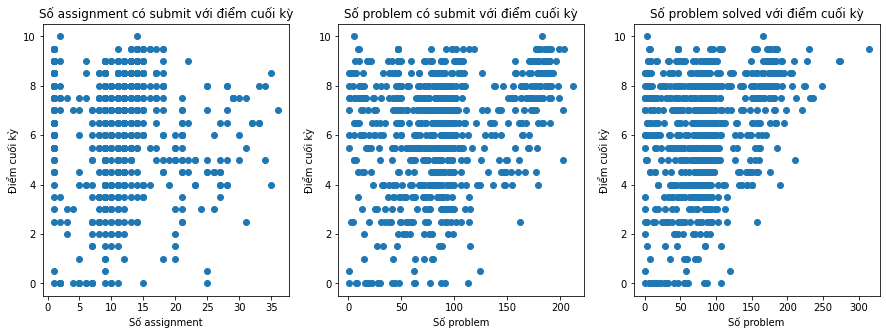

In [619]:
fix, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.scatter(final_df.no_assignment, final_df.CK)
ax1.set_title('Số assignment có submit với điểm cuối kỳ')
ax1.set(xlabel='Số assignment', ylabel='Điểm cuối kỳ')

ax2.scatter(final_df.no_problem, final_df.CK)
ax2.set_title('Số problem có submit với điểm cuối kỳ')
ax2.set(xlabel='Số problem', ylabel='Điểm cuối kỳ')

ax3.scatter(final_df.no_solved, final_df.CK)
ax3.set_title('Số problem solved với điểm cuối kỳ')
ax3.set(xlabel='Số problem', ylabel='Điểm cuối kỳ')

plt.show()

Đối với 3 biểu đồ trên, cả 3 đều thể hiện các điểm chủ yếu phân bố hình tam giác phía trên bên trái (đường chéo phụ), điều này nghĩa là khi số assignment, problem và problem solved nhiều thì điểm số của sinh viên có xu hướng tăng dần về 10. Tuy nhiên đối với biểu đồ 1 thì phân bố chưa thực sự rõ ràng, cho nên số assignment có thể ảnh hưởng ít đến điểm thi cuối kỳ.

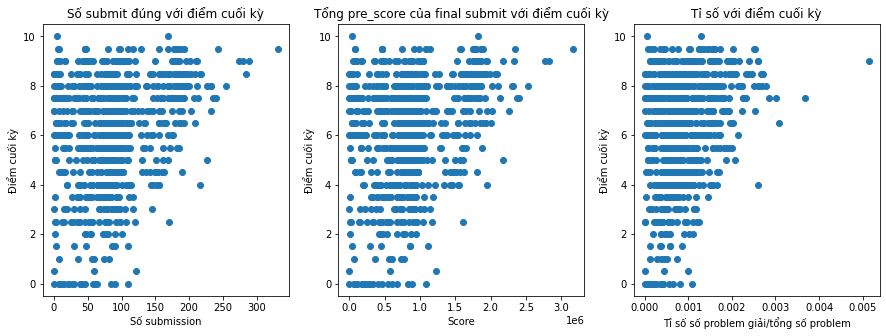

In [620]:
fix, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.scatter(final_df.no_correct_submission, final_df.CK)
ax1.set_title('Số submit đúng với điểm cuối kỳ')
ax1.set(xlabel='Số submission', ylabel='Điểm cuối kỳ')

ax2.scatter(final_df.sum_pre_score_final, final_df.CK)
ax2.set_title('Tổng pre_score của final submit với điểm cuối kỳ')
ax2.set(xlabel='Score', ylabel='Điểm cuối kỳ')

ax3.scatter(final_df.no_submission__no_submission, final_df.CK)
ax3.set_title('Tỉ số với điểm cuối kỳ')
ax3.set(xlabel='Tỉ số số problem giải/tổng số problem', ylabel='Điểm cuối kỳ')

plt.show()

Tương tự như 3 biểu đồ phía trên, số submission, score và tỉ số problem có submit/tổng số problem cao thì điểm thi sinh viên có xu hướng tăng dần về 10. Điều này có nghĩa là 3 feature này đều có ảnh hưởng đến kết quả thi CK

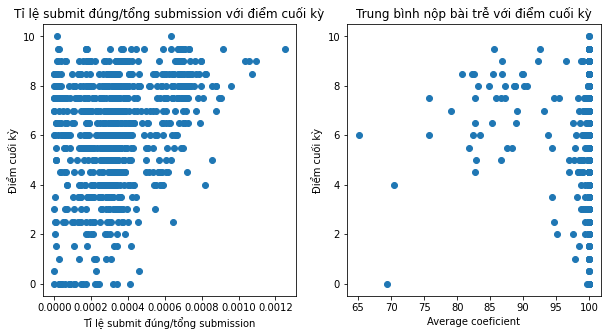

In [621]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('Tỉ lệ submit đúng/tổng submission với điểm cuối kỳ')
ax1.scatter(final_df.no_correct_submission__no_submission, final_df.CK)
ax1.set(xlabel='Tỉ lệ submit đúng/tổng submission', ylabel='Điểm cuối kỳ')

ax2.set_title('Trung bình nộp bài trễ với điểm cuối kỳ')
ax2.scatter(final_df.avg_coefficient, final_df.CK)
ax2.set(xlabel='Average coeficient', ylabel='Điểm cuối kỳ')

plt.show()

Tương tự như feature bên trên thì tỉ lệ submit đúng/tổng submission cao thì sinh viên có xu hướng thi được điểm gần 10 hơn.

Tuy nhiên với coefficient thì phân bố tập trung chủ yếu về bên phải (coefficient = 100), có một nhóm nhỏ tập trung từ khoảng 75 đến 95. Như vậy có thể là sinh viên ở khoảng này thì có khả năng đạt điểm cao hơn.

# Dự đoán điểm cuối kỳ

Sau khi đã tính toán và phân tích các thông số từ tập wecode, chúng ta có thể sử dụng để bắt đầu dự đoán điểm CK.

In [622]:
score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      975 non-null    int64  
 1   QT      891 non-null    float64
 2   GK      836 non-null    float64
 3   TH      892 non-null    float64
 4   CK      920 non-null    float64
 5   TBM     786 non-null    float64
 6   TBTL    972 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 53.4 KB


Chúng ta cần tách điểm cuối kỳ bị null (vị trí cần dự đoán) và điểm cuối kỳ không null (dùng cho việc đánh giá và train mô hình).

In [623]:
# Tách các data point có giá trị CK là null và không null
null_dset = final_df[final_df.CK.isnull()]
not_null_dset = final_df[final_df.CK.notnull()]

In [624]:
null_dset.head()

,user_id,no_assignment,no_problem,no_submission,no_solved,no_correct_submission,sum_pre_score_final,avg_coefficient,no_solved__no_problem,no_submission__no_submission,no_correct_submission__no_submission,CK
14,51,5,39,86,38,40,380000,100.000000,0.974359,0.000325,0.000151,NaN
96,240,15,123,623,126,133,1309761,93.914928,1.024390,0.002354,0.000503,NaN
164,391,14,111,379,102,104,1059240,94.168865,0.918919,0.001432,0.000393,NaN
240,513,15,135,672,130,135,1319307,102.470238,0.962963,0.002540,0.000510,NaN
278,586,15,124,296,123,127,1238947,103.462838,0.991935,0.001119,0.000480,NaN


In [625]:
not_null_dset.head()

,user_id,no_assignment,no_problem,no_submission,no_solved,no_correct_submission,sum_pre_score_final,avg_coefficient,no_solved__no_problem,no_submission__no_submission,no_correct_submission__no_submission,CK
0,24,15,78,164,72,80,750299,100.0,0.923077,0.000620,0.000302,9.5
1,27,2,5,13,3,4,39000,100.0,0.600000,0.000049,0.000015,10.0
2,29,13,80,199,72,75,762760,100.0,0.900000,0.000752,0.000283,8.5
3,34,11,84,218,81,81,822888,100.0,0.964286,0.000824,0.000306,6.5
4,35,25,147,297,145,152,1477000,100.0,0.986395,0.001122,0.000574,4.5


In [626]:
not_null_dset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806 entries, 0 to 852
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   user_id                               806 non-null    int64  
 1   no_assignment                         806 non-null    int64  
 2   no_problem                            806 non-null    int64  
 3   no_submission                         806 non-null    int64  
 4   no_solved                             806 non-null    int64  
 5   no_correct_submission                 806 non-null    int64  
 6   sum_pre_score_final                   806 non-null    int64  
 7   avg_coefficient                       806 non-null    float64
 8   no_solved__no_problem                 806 non-null    float64
 9   no_submission__no_submission          806 non-null    float64
 10  no_correct_submission__no_submission  806 non-null    float64
 11  CK                 

Chúng ta cần phải drop cột user_id vì nó không đóng góp gì vào việc training hay testing cả

In [627]:
not_null_dset.drop(['user_id'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Tiếp theo chúng ta sẽ phải chia tập not_null_dset thành tập train và tập test

In [628]:
# Tách tập not_null_dset thành X (features) và y (label)
X = not_null_dset.iloc[:, :-1].values
y = not_null_dset.iloc[:, -1].values

In [629]:
# Chia thành tập train và test theo tỉ lệ 8/2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (685, 10)
Shape of X_test: (121, 10)
Shape of y_train: (685,)
Shape of y_test: (121,)


In [630]:
# Normalize giá trị về khoảng giá trị gần 0 để tính toán nhanh hơn
# Normalize giá trị nguyên về khoảng giá trị nhỏ hơn để tính toán nhanh hơn
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
not_null_dset = sc.fit_transform(not_null_dset)

not_null_dset[:5]

array([[ 0.55411903, -0.22809705, -0.45832268, -0.27682624, -0.19159057,
        -0.26459632,  0.25079645,  0.02528729, -0.45832268, -0.19159057,
         1.48398056],
       [-1.3988104 , -1.72161746, -1.38355856, -1.58174355, -1.54616954,
        -1.58369708,  0.25079645, -1.57808301, -1.38355856, -1.54616954,
         1.70696496],
       [ 0.25366835, -0.18717869, -0.24386404, -0.27682624, -0.28070761,
        -0.24148745,  0.25079645, -0.08923916, -0.24386404, -0.28070761,
         1.03801176],
       [-0.04678233, -0.10534195, -0.12744363, -0.10661963, -0.17376717,
        -0.12998035,  0.25079645,  0.2297988 , -0.12744363, -0.17376717,
         0.14607415],
       [ 2.05637243,  1.18358662,  0.35662017,  1.10373845,  1.09169477,
         1.08306739,  0.25079645,  0.33952085,  0.35662017,  1.09169477,
        -0.74586346]])

Như vậy chúng ta sẽ có 685 data point cho việc training và 121 data point cho việc testing.

Bây giờ chúng ta sẽ thực nghiệm qua các mô hình khác nhau để chọn ra mô hình phù hợp nhất với dữ liệu của chúng ta. Độ đo được sử dụng sẽ là $R^2$, MSE và MAE. Vậy để đánh giá thì trước tiên ta xem thử giá trị trung bình của y_test như thế nào.

In [631]:
mean_y_test = y_test.mean()

In [632]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Linear Regression

In [645]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean y test: {mean_y_test}")
print(f"MAE: {mae}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2 Score: 0.2160431451227386
Mean y test: 6.1735537190082646
MAE: 1.5354663408128206
MSE: 3.71799878107267


In [646]:
print(f"y_test\ty_pred")
for i in range(10):
  print(f"{y_test[i]}\t{y_pred[i]}")

y_test	y_pred
9.0	6.723904607596369
8.0	6.377330465787498
7.5	6.72019545010261
7.0	6.189308562805962
2.5	5.687323895600753
3.0	5.184443757697611
8.5	7.3657760270942205
6.0	7.442231923379152
0.0	6.042106669986069
6.0	6.058016030866305


## SVR

In [647]:
from sklearn.svm import SVR
model = SVR()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean y test: {mean_y_test}")
print(f"MAE: {mae}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2 Score: 0.07116720734935678
Mean y test: 6.1735537190082646
MAE: 1.6915863573897068
MSE: 4.405088327770398


In [648]:
print(f"y_test\ty_pred")
for i in range(10):
  print(f"{y_test[i]}\t{y_pred[i]}")

y_test	y_pred
9.0	6.486239623966118
8.0	5.826467532833639
7.5	6.237040887255413
7.0	6.370397670677415
2.5	5.957626118655139
3.0	6.629453899212649
8.5	7.682937570448583
6.0	7.4488321374660735
0.0	5.842337681329699
6.0	6.40298316949265


Khi áp dụng SVR thì kết quả cho ra còn tệ hơn LinearRegression

## Decision tree regressor

In [649]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean y test: {mean_y_test}")
print(f"MAE: {mae}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2 Score: -0.3348311046783752
Mean y test: 6.1735537190082646
MAE: 1.8677685950413223
MSE: 6.330578512396694


In [650]:
print(f"y_test\ty_pred")
for i in range(10):
  print(f"{y_test[i]}\t{y_pred[i]}")

y_test	y_pred
9.0	8.0
8.0	8.0
7.5	7.5
7.0	7.5
2.5	3.5
3.0	4.5
8.5	6.5
6.0	8.0
0.0	6.0
6.0	7.0


## RandomForestRegressor

In [651]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean y test: {mean_y_test}")
print(f"MAE: {mae}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2 Score: 0.2610115792846701
Mean y test: 6.1735537190082646
MAE: 1.521115702479339
MSE: 3.5047311983471072


In [652]:
print(f"y_test\ty_pred")
for i in range(10):
  print(f"{y_test[i]}\t{y_pred[i]}%")

y_test	y_pred
9.0	7.06%
8.0	7.835%
7.5	5.935%
7.0	5.91%
2.5	4.91%
3.0	4.925%
8.5	6.325%
6.0	7.085%
0.0	5.53%
6.0	6.14%


Sau khi chạy thử thì có thể thấy RandomForestRegressor đang cho kết quả cao nhất.

## Thử áp dụng PCA để giảm số chiều dữ liệu

In [653]:
from sklearn.decomposition import PCA
pca = PCA(6, random_state=42)

pca.fit(X_train)

X_train_reduced = pca.transform(X_train)

In [654]:
print(X_train_reduced[:3])

[[ 9.29492267e+05  1.13699192e+02 -2.89248524e+00 -6.92163390e+00
  -4.99084313e+00  1.12338925e+01]
 [-1.70765808e+05  2.70323866e+01 -1.45115204e+00 -7.63889572e+00
   1.20138071e+00 -1.01243273e+00]
 [-4.37967840e+05 -5.34200782e+01  5.29940544e+00  3.69074145e+00
  -7.27057840e+00 -1.37814506e+00]]


Sau khi áp dụng PCA thì tiếp tục thử lại các phương pháp tốt nhất ở phía trên.

In [655]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_reduced, y_train)

y_pred = model.predict(pca.transform(X_test))

mae = mean_absolute_error(y_test, y_pred)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean y test: {mean_y_test}")
print(f"MAE: {mae}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2 Score: 0.2096870989098395
Mean y test: 6.1735537190082646
MAE: 1.5401390871249883
MSE: 3.748143006389381


In [656]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train_reduced, y_train)

y_pred = model.predict(pca.transform(X_test))

mae = mean_absolute_error(y_test, y_pred)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean y test: {mean_y_test}")
print(f"MAE: {mae}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2 Score: 0.27999605172581743
Mean y test: 6.1735537190082646
MAE: 1.449693526170799
MSE: 3.4146953182392097


# Kết luận

Như vậy có thể thấy là việc dự đoán điểm dựa trên quá trình nộp bài Wecode là chưa khả quan.